# Question 3 Flower Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".
- You only need to modify code in the "TODO" part. We added some "assertions" to check your code. **Do not** modify them.

In [ ]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
from torch.optim import Adam
import random 
from tqdm import tqdm 
import warnings 

You can upload your image folder on Google drive and access image folder from it. **Skip it if you run on local machine.** To mount google drive to your current colab page, use the following command 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Tesla K80.......



## P1. Data augmentation and plotting
### TODO
- Design your image augmentation method for transform_image
- Load train and test data, and split them into train_loader and test_loader 
- Visualize your augmented image 





In [ ]:
# TODO: define your image augmentation method
# Make sure to crop the image in (3,224,224) using transforms.RandomResizedCrop(224)  
transform_image = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()]) 

#/Users/sagarsachdev/Documents/Grad_School/FALL2021/Machine Learning and Artificial Intelligence for Engineers/HW5/q3_data/flowers
# TODO: Load data using ImageFolder. Specify your image folder path 
path = '/content/drive/MyDrive/flowers/'
dataset = datasets.ImageFolder(path,transform=transform_image)

n = len(dataset)
n_test = int(0.1 * n) 

# Split data into features(pixels) and labels(numbers from 0 to 4)
train_dataset, test_dataset = random_split(dataset, (n-n_test,n_test))
train_loader, test_loader = DataLoader(train_dataset, batch_size=16, shuffle=True), DataLoader(test_dataset, batch_size=16, shuffle=True)

(-0.5, 223.5, 223.5, -0.5)

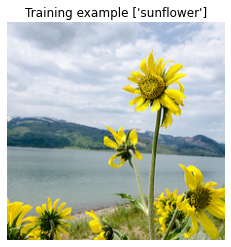

In [ ]:
# Sample output
label_map = [['daisy'],['dandelion'],['rose'],['sunflower'],['tulip']]
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)


assert np.array_equal(image[0].detach().numpy().shape, [3,224,224])

plt.imshow(image[0].permute(1,2,0))
plt.title(f"Training example {label_map[image[1]]}")
plt.axis('off')

## P2. Build you own CNN model 
### TODO
- Design your own model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 
- Plot your first convolution layer kernels using **plot_filters_multi_channel()**

###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- You may want to use small learning rate for training. (eg. 1e-5)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel
So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:

**stide:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll use the next structure shown in the comment:

*input -> convolution -> pooling -> fully connected -> output* \\

**Convolution #1**

16 kernels of 5x5; *Width/Height:* (224 - 5 + 2x0) / 1 + 1 = 220; *Output dimensions:* (16, 220, 220)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (220 - 2) / 2 + 1 = 110; *Output dimensions:* (16, 110, 110)

So at the end of the last convolutional layer we get a tensor of dimension (16, 110, 110). And since now we are going to feed it to fully connected classifier, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [ ]:
#add more channels,more cnn layers, changing learning rate, batch norm and dropout 
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers 
    # Example:  
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #(16,220,220)
    self.relu1 = nn.ReLU() 
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    # self.cnn1 = None     

    # my_code
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) #(32,216,216)
    self.relu2 = nn.ReLU() 
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #filter size = 2, stride = 2; Width/Height: (216 - 2) / 2 + 1 = 108; Output dimensions: (20, 108, 108)


    self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) #35 kernels of 3x3;Width/Height: (55-3+2x1)/1 +1 = 55; Output dimensions: (35,55,55)
    self.relu3 = nn.ReLU() 
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #filter size = 2, stride = 2; Width/Height: (55 - 2) / 2 + 1 = 27.5; Output dimensions: (20, 27.5, 27.5)

  

    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
   #my_code
    # Fully connected 1
    self.fc1 = nn.Linear(46656,512) 
    self.fc2 = nn.Linear(512,64)
    self.fc3 = nn.Linear(64,5)
    

  def forward(self,x):
    # TODO: Perform forward pass in blow section 
    # Example:
    out = self.cnn1(x)
    out = self.relu1(out) 
    out = self.maxpool1(out) 
    
    out = self.cnn2(out)
    out = self.relu2(out) 
    out = self.maxpool2(out) 
    
    out = self.cnn3(out)
    out = self.relu3(out)
    out = self.maxpool3(out) 
  
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)

    
    # out = self.fc(out)
    return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [ ]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.0010
optimizer = Adam(model.parameters(),learning_rate)

num_epochs = 50

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and ross entropy loss
        loss = error(outputs,labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  4%|▍         | 2/50 [01:07<27:14, 34.04s/it]

Iteration: 500  Loss: 1.60098135471344  Accuracy: 42.22737503051758 %


  8%|▊         | 4/50 [02:16<26:22, 34.40s/it]

Iteration: 1000  Loss: 1.2657495737075806  Accuracy: 49.88398742675781 %


 12%|█▏        | 6/50 [03:25<25:16, 34.47s/it]

Iteration: 1500  Loss: 0.5565648078918457  Accuracy: 55.45243453979492 %


 16%|█▌        | 8/50 [04:32<23:39, 33.80s/it]

Iteration: 2000  Loss: 0.9424199461936951  Accuracy: 62.180973052978516 %


 20%|██        | 10/50 [05:42<22:55, 34.39s/it]

Iteration: 2500  Loss: 1.082531452178955  Accuracy: 63.109046936035156 %


 24%|██▍       | 12/50 [06:51<21:52, 34.55s/it]

Iteration: 3000  Loss: 1.34209144115448  Accuracy: 64.7331771850586 %


 28%|██▊       | 14/50 [08:01<20:50, 34.73s/it]

Iteration: 3500  Loss: 0.789823591709137  Accuracy: 60.78886032104492 %


 32%|███▏      | 16/50 [09:09<19:28, 34.36s/it]

Iteration: 4000  Loss: 1.1929826736450195  Accuracy: 64.96519470214844 %


 36%|███▌      | 18/50 [10:18<18:19, 34.37s/it]

Iteration: 4500  Loss: 0.6514575481414795  Accuracy: 66.35730743408203 %


 40%|████      | 20/50 [11:26<17:10, 34.36s/it]

Iteration: 5000  Loss: 0.6628984808921814  Accuracy: 67.05335998535156 %


 44%|████▍     | 22/50 [12:34<15:47, 33.85s/it]

Iteration: 5500  Loss: 0.48242923617362976  Accuracy: 66.12528991699219 %


 48%|████▊     | 24/50 [13:43<14:52, 34.34s/it]

Iteration: 6000  Loss: 0.7482051253318787  Accuracy: 70.30162048339844 %


 52%|█████▏    | 26/50 [14:53<13:50, 34.62s/it]

Iteration: 6500  Loss: 0.612602174282074  Accuracy: 68.44547271728516 %


 56%|█████▌    | 28/50 [16:03<12:45, 34.78s/it]

Iteration: 7000  Loss: 0.6748406887054443  Accuracy: 66.82134246826172 %


 60%|██████    | 30/50 [17:10<11:24, 34.24s/it]

Iteration: 7500  Loss: 0.5961849689483643  Accuracy: 69.37355041503906 %


 64%|██████▍   | 32/50 [18:20<10:23, 34.63s/it]

Iteration: 8000  Loss: 0.694313645362854  Accuracy: 68.21345520019531 %


 68%|██████▊   | 34/50 [19:30<09:15, 34.73s/it]

Iteration: 8500  Loss: 1.0884250402450562  Accuracy: 64.96519470214844 %


 74%|███████▍  | 37/50 [21:12<07:26, 34.38s/it]

Iteration: 9000  Loss: 0.8722015619277954  Accuracy: 71.22969818115234 %


 78%|███████▊  | 39/50 [22:22<06:20, 34.64s/it]

Iteration: 9500  Loss: 0.9240458011627197  Accuracy: 67.51740264892578 %


 82%|████████▏ | 41/50 [23:31<05:11, 34.62s/it]

Iteration: 10000  Loss: 1.0731157064437866  Accuracy: 69.83758544921875 %


 86%|████████▌ | 43/50 [24:38<03:57, 33.92s/it]

Iteration: 10500  Loss: 0.8446602821350098  Accuracy: 71.22969818115234 %


 90%|█████████ | 45/50 [25:47<02:51, 34.25s/it]

Iteration: 11000  Loss: 0.561721682548523  Accuracy: 73.08584594726562 %


 94%|█████████▍| 47/50 [26:57<01:43, 34.51s/it]

Iteration: 11500  Loss: 0.548560619354248  Accuracy: 73.54988098144531 %


 98%|█████████▊| 49/50 [28:06<00:34, 34.60s/it]

Iteration: 12000  Loss: 0.9695340394973755  Accuracy: 73.78189849853516 %


100%|██████████| 50/50 [28:41<00:00, 34.43s/it]


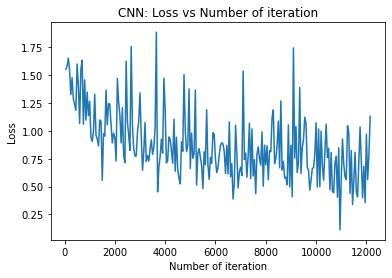

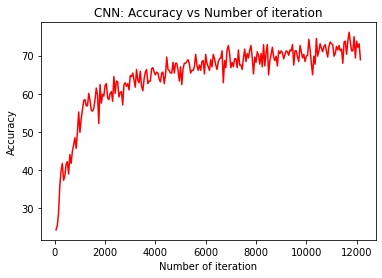

In [ ]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### Evaluating the Model

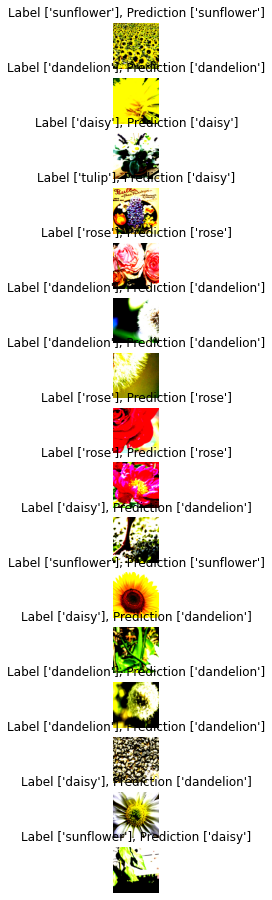

In [ ]:
# Evaluate your model
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = len(labels)
fig = plt.figure(figsize=(num_cols,num_rows))
for idx in range(num_rows):
  ax1 = fig.add_subplot(num_rows,num_cols,idx+1)
  img = images.cpu().detach()[idx].numpy()
  img = (img - np.mean(img)) / np.std(img)
  img = np.minimum(1, np.maximum(0, (img + 0.5)))
  ax1.imshow(img.transpose((1,2,0)))
  
  ax1.set_title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")
  ax1.axis('off')
plt.savefig('Prediction.png', dpi=100)    
plt.show()

### Visualizing your first layer filter 

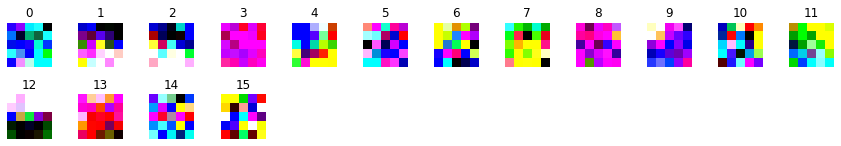

In [ ]:
# plot your first layer kernels 

def plot_filters_multi_channel(t):
    #make sure the input channel is 3 
    assert(t.shape[1]==3)

    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12

    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().detach().numpy(), np.float32)
        
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('Filter.png', dpi=100)    
    plt.tight_layout()
    plt.show()

plot_filters_multi_channel(list(model.parameters())[0])